1.1 Data Collection
Label Areas:


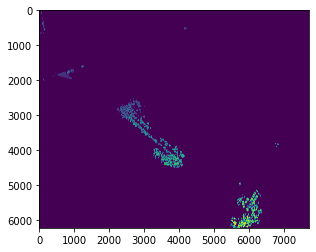

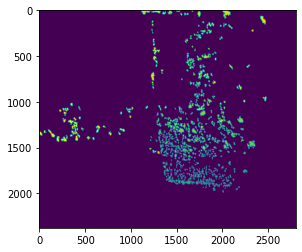

1.2 Patch Generation
Mask/Label Patch Shape: 1038
Satellite Patch Shape: 1038
BoundingBox(left=29.748165907, bottom=-26.263430008, right=29.766500302, top=-26.248664052)
BoundingBox(left=29.995271839179495, bottom=-26.501297921923136, right=30.001920300509017, top=-26.495656803219298)
Single Patch:


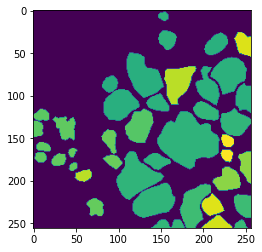

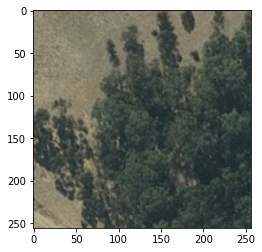

1.3 Data Preparation for Training
Shape of One Label and Satellite Patch: (256, 256) (3, 256, 256)
Sanity Check of a Single Patch:


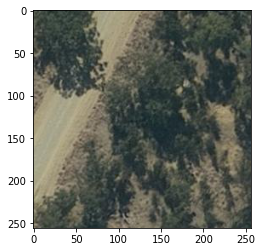

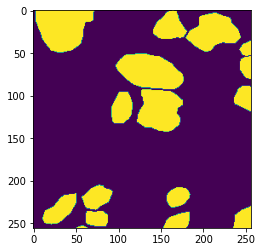

(664, 256, 256, 3) (664, 256, 256) (208, 256, 256, 3)


In [2]:
%run "1_data_preparation.ipynb"

In [ ]:
%%time
loss_history = model.fit(datagen.flow(X_train_mini_np, y_train_mini_np,
                                batch_size=config.BATCH_SIZE, subset='training'),
                        epochs=config.NB_EPOCHS,
                        steps_per_epoch=len(X_train_mini_np) // config.BATCH_SIZE, #config.MAX_TRAIN_STEPS, # steps_per_epoch * epochs <= # data instances = 94
                        validation_data=datagen.flow(X_val_np, y_val_np, 
                                batch_size=config.BATCH_SIZE, subset='validation'),
                        validation_steps=len(X_train_mini_np) // config.BATCH_SIZE,
                        batch_size=config.BATCH_SIZE,
                        callbacks=callbacks_list
                        # use_multiprocessing=True # the generator is not very thread safe
                )
print("Training completed.")

# Data Access & Exploration

## 0. Imports

In [4]:
import os.path
from os.path import isfile, join
import os
from os import listdir
from osgeo import gdal
import errno
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.windows import from_bounds #Window
from rasterio.enums import Resampling
from sys import platform

In [5]:
# Load config
from config import config, colors
config = config.Configuration()
colors = colors.bcolors()

# 1. Data Inspection

### 1.1 Functions

In [57]:
def inspect_tif_resolution(filepath):
    img = rasterio.open(filepath)
    xRes, yRes = img.res
    print("Resolution: {} x {}".format(xRes, yRes))

In [58]:
inspect_tif_resolution(config.filepath_label)
inspect_tif_resolution(config.filepath_satellite)

Resolution: 2.372814311058536e-06 x 2.372814310098498e-06
Resolution: 2.3728143101288307e-06 x 2.3728143101288515e-06


In [74]:
exported = (2.372814311058536e-06, 2.372814310098498e-06)
satellite = (2.3728143101288307e-06, 2.3728143101288515e-06)

diff = (abs(exported[0]-satellite[0]),abs(exported[1]-satellite[1]))
mult_to_m = 100000
mult_to_cm = mult_to_m * 100
mult_to_mm = mult_to_cm * 10
faktor = 100000000
print(diff[0]*mult_to_cm*faktor, diff[1]*mult_to_cm*faktor)

0.9297050569722145 0.030353425664857853


In [ ]:
# cm: 9.297050569722146e-09 3.0353425664857853e-10
# 

In [3]:
def bounds(filepath):
    src_img = rasterio.open(filepath)
    print(src_img.bounds)
    left, bottom, right, top = src_img.bounds[0],src_img.bounds[1], src_img.bounds[2], src_img.bounds[3]


In [5]:
bounds(config.filepath_label_nw)

BoundingBox(left=29.748165907, bottom=-26.263430008, right=29.766500302, top=-26.248664052)


In [7]:
str = "https://commons.wikimedia.org/wiki/file:South_Africa_blank_locator_map.svg"
str.lower()

'https://commons.wikimedia.org/wiki/file:south_africa_blank_locator_map.svg'

In [60]:
def inspect_tif(dataset):
    print("Metadata:", dataset.GetMetadata())
    print("Projection: ", dataset.GetProjection())
    print("Size is {} x {} x {}".format(dataset.RasterXSize,
                                        dataset.RasterYSize,
                                        dataset.RasterCount))
    geotransform = dataset.GetGeoTransform()
    if geotransform:
        print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
        print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))

    # Get First Raster Band
    band = dataset.GetRasterBand(1)
    min = band.GetMinimum()
    max = band.GetMaximum()
    if not min or not max:
        (min,max) = band.ComputeRasterMinMax(True)
    print("Min={:.3f}, Max={:.3f}".format(int(min),int(max)))
        
    size_x_px = dataset.RasterXSize
    size_y_px = dataset.RasterYSize
    pixel_size = (dataset.GetGeoTransform()[1], dataset.GetGeoTransform()[5])
    size_x = size_x_px * pixel_size[0]
    size_y = size_y_px * pixel_size[1]
    print("# Pixels in Image = ({}, {}) with a Raster Count of {}".format(size_x_px, size_y_px, dataset.RasterCount))
    mult_to_m = 100000
    mult_to_km = mult_to_m / 1000
    print("Size of one Pixel in m = {}".format(tuple([mult_to_m*x for x in pixel_size])))
    print("Size Covered by Image / Image Size = ({}km, {}km)".format(round(mult_to_km*size_x, 2), abs(round(mult_to_km*size_y, 2))))

In [8]:
filepath_satellite_server = config.path_data + '1_labeled_data/tif/exported.tif'
filepath_satellite_server

'/Users/leori/Desktop/BA/1_Data/1_labeled_data/tif/exported.tif'

In [9]:
inspect_tif(gdal.Open(config.filepath_label_compressed))

Metadata: {'AREA_OR_POINT': 'Area'}
Projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Size is 108224 x 107798 x 1
Origin = (29.746877767, -26.247113163)
Pixel Size = (2.372814311058536e-06, -2.372814310098498e-06)
Min=123.000, Max=1663.000
# Pixels in Image = (108224, 107798) with a Raster Count of 1
Size of one Pixel in m = (0.2372814311058536, -0.2372814310098498)
Size Covered by Image / Image Size = (25.68km, 25.58km)


In [ ]:
label_img_se = gdal.Open(config.filepath_label_se)
label_img_nw = gdal.Open(config.filepath_label_nw)

In [ ]:
inspect_tif(label_img_se)
inspect_tif(label_img_nw)

Metadata: {'AREA_OR_POINT': 'Area'}
Projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Size is 2802 x 2377 x 1
Origin = (29.995271839179495, -26.495656803219298)
Pixel Size = (2.3727556493655776e-06, -2.373209383188281e-06)
Min=946.000, Max=1668.000
# Pixels in Image = (2802, 2377) with a Raster Count of 1
Size of one Pixel in m = (0.23727556493655777, -0.23732093831882808)
Size Covered by Image / Image Size = (0.66km, 0.56km)
Metadata: {'AREA_OR_POINT': 'Area'}
Projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Si

In [ ]:
patch_size = 256
overlap = 32
def calc_patch_num(width, height):
    row_patches = int((width - 2 * overlap) / (patch_size - overlap))
    col_patches = int((height - 2 * overlap) / (patch_size - overlap))
    print("{} * {} = {}".format(row_patches, col_patches, row_patches*col_patches))

calc_patch_num(2802, 2377)
calc_patch_num(7727, 6223)

12 * 10 = 120
34 * 27 = 918


In [ ]:
# preview_tif(filepath_satellite_server)

In [ ]:
opened_label_areas = [
    rasterio.open(config.filepath_label_nw),
    rasterio.open(config.filepath_label_se)]
label_area = opened_label_areas[0]
cur_coords = (west, south, east, north) = label_area.bounds
label_area = label_area.read(1, window = from_bounds(west, south, east, north, label_area.transform))

BoundingBox(left=29.746877767434313, bottom=-26.502897800020722, right=30.003673223333696, top=-26.247113163017453)


In [10]:
inspect_tif(gdal.Open(config.filepath_label_nw))
inspect_tif(gdal.Open(config.filepath_label_se))

Metadata: {'AREA_OR_POINT': 'Area'}
Projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Size is 7727 x 6223 x 1
Origin = (29.748165907, -26.248664052)
Pixel Size = (2.372770156593777e-06, -2.372803470994942e-06)
Min=130.000, Max=941.000
# Pixels in Image = (7727, 6223) with a Raster Count of 1
Size of one Pixel in m = (0.2372770156593777, -0.2372803470994942)
Size Covered by Image / Image Size = (1.83km, 1.48km)
Metadata: {'AREA_OR_POINT': 'Area'}
Projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Size is 2802 x 237

In [ ]:
inspect_tif(gdal.Open(filepath_satellite_server))

Metadata: {'AREA_OR_POINT': 'Area'}
Projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Size is 108224 x 107798 x 1
Origin = (29.746877767, -26.247113163)
Pixel Size = (2.372814311058536e-06, -2.372814310098498e-06)
Min=123.000, Max=1663.000
# Pixels in Image = (108224, 107798) with a Raster Count of 1
Size of one Pixel in m = (0.2372814311058536, -0.2372814310098498)
Size Covered by Image / Image Size = (25.68km, 25.58km)


In [ ]:
def isfile(filepath: str = None):
    # if filepath does not exists, an error is thrown
    if not os.path.isfile(filepath): raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), filepath) #print("File does not exist.")

In [ ]:
def check_filesize(filepath, size_in_mb: int = 500):
    filesize_in_mb = os.path.getsize(filepath) / 1000000
    if filesize_in_mb > size_in_mb: 
        raise Exception("File is too large: {}MB".format(int(filesize_in_mb)))

In [ ]:
def preview_tif(tif_filepath: str = None):
    isfile(tif_filepath)
    check_filesize(tif_filepath, 50)
    img = rasterio.open(tif_filepath)
    if img: show(img)
    else: print("img unable to be loaded at this moment")

### 1.2 Data Inspection

ToDos Data Preparation
- Data Cleaning (visualize data first): rm redundant information & set no data values to something - some metadata?
- Custom Transformers
- Feature Scaling


⇒ Pipeline (cf. first example in `4_pipeline.ipynb`)

In [ ]:
filepath_label = config.filepath_label
filepath_satellite = config.filepath_satellite

satel 29.746877767434313, -26.247113163017453
label 29.746877767,       -26.247113163

In [ ]:
# actual version
print("Satellite")
inspect_tif(gdal.Open(filepath_satellite))
bounds(filepath_satellite)

print("\nLabel")
inspect_tif(gdal.Open(filepath_label))
bounds(filepath_label)

Satellite
Metadata: {'ALL_COMMENTS': 'Created by OpenJPEG version 2.4.0', 'AREA_OR_POINT': 'Area', 'COLORSPACE': 'RGB', 'COMPRESSION_RATE_TARGET': '1', 'TIFFTAG_MAXSAMPLEVALUE': '0', 'TIFFTAG_MINSAMPLEVALUE': '0', 'TIFFTAG_RESOLUTIONUNIT': '1 (unitless)', 'TIFFTAG_XRESOLUTION': '0', 'TIFFTAG_YRESOLUTION': '0'}
Projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Size is 108224 x 107798 x 3
Origin = (29.746877767434313, -26.247113163017453)
Pixel Size = (2.3728143101288307e-06, -2.3728143101288515e-06)
Min=0.000, Max=255.000
# Pixels in Image = (108224, 107798) with a Raster Count of 3
Size of one Pixel in m = (0.23728143101288307, -0.23728143101288515)
Size Covered by Image / Image Size = (25.68km, 25.58km)
BoundingBox(left=29.746877767434313, bottom=-

In [ ]:
2.3728143101288307e-06, -2.3728143101288515e-06
2.372814311058536e-06,  -2.372814310098498e-06

- Size of one Pixel in cm = (0.23728143101288307, -0.23728143101288515)
- Size of one Pixel in cm = (0.23728143099711865, -0.23728143123798187)

- Size Covered by Image / Image Size = (256.8m, 255.78m)
- Size Covered by Image / Image Size = (252.93m, 251.7m)

- BoundingBox(left=29.746877767434313, bottom=-26.502897800020722, right=30.003673223333696, top=-26.247113163017453)
- BoundingBox(left=29.748224553,       bottom=-26.50038228,        right=30.00115944,        top=-26.248683629)

- Size is 108224 x 107798 x 3
- Size is 106597 x 106076 x 1

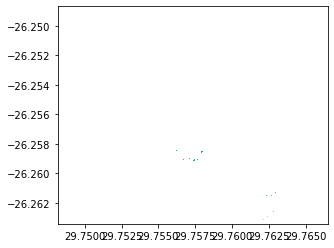

In [ ]:
preview_tif(config.filepath_label_nw)

In [ ]:
cutout_window = (29.748021463931796, -26.24839922837354, 29.74923634485858, -26.249614109300325)

In [ ]:
check_filesize(config.filepath_label, 1000)
src_label = rasterio.open(config.filepath_label)
print("shape:", src_label.read().shape)
# src_label.colorinterp[3] # rgba

Exception: File is too large: 46667MB

In [ ]:
# compressed label
check_filesize(filepath_satellite_server, 1000)
src_label = rasterio.open(filepath_satellite_server)
print("shape:", src_label.read().shape)
# src_label.colorinterp[3] # rgba

In [ ]:
check_filesize(config.filepath_satellite, 1000)
src_satellite.read().shape
# src_satellite.read(2)[1884-1][3050-1] # blue pixel value in bottom left corner

Exception: File is too large: 46666MB

In [ ]:
from PIL import Image
import numpy as np

img = Image.open(filepath_label)

# convert to numpy array
img = np.array(img)

# find number of channels
if img.ndim == 2:
    channels = 1
    print("image has 1 channel")
else:
    channels = img.shape[-1]
    print("image has", channels, "channels")

image has 4 channels


### 1.3 Data Visualization

In [ ]:
# inspect_tif_resolution(filepath_satellite)
inspect_tif_resolution(filepath_label)
inspect_tif_resolution(filepath_satellite_server)

Resolution: 2.372814311058536e-06 x 2.372814310098498e-06
Resolution: 2.372814311058536e-06 x 2.372814310098498e-06


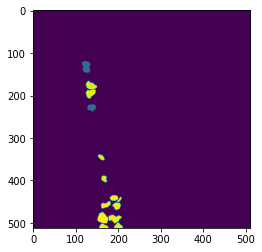

<AxesSubplot:>

In [ ]:
(west, north, east, south) = cutout_window
labels_compressed = rasterio.open(filepath_satellite_server)
labels_compressed_window = labels_compressed.read(1, window = from_bounds(west, south, east, north, labels_compressed.transform))
show(labels_compressed_window)

In [ ]:
print("Compressed Label")
inspect_tif(gdal.Open(filepath_satellite_server))
bounds(filepath_satellite_server)

Compressed Label
Metadata: {'AREA_OR_POINT': 'Area'}
Projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Size is 108224 x 107798 x 1
Origin = (29.746877767, -26.247113163)
Pixel Size = (2.372814311058536e-06, -2.372814310098498e-06)
Min=123.000, Max=1663.000
# Pixels in Image = (108224, 107798) with a Raster Count of 1
Size of one Pixel in m = (0.2372814311058536, -0.2372814310098498)
Size Covered by Image / Image Size = (25.68km, 25.58km)
BoundingBox(left=29.746877767, bottom=-26.5028978, right=30.003673223, top=-26.247113163)


# 2. Archive

In [1]:
"""Satellite
Metadata: {'ALL_COMMENTS': 'Created by OpenJPEG version 2.4.0', 'AREA_OR_POINT': 'Area', 'COLORSPACE': 'RGB', 'COMPRESSION_RATE_TARGET': '1', 'TIFFTAG_MAXSAMPLEVALUE': '0', 'TIFFTAG_MINSAMPLEVALUE': '0', 'TIFFTAG_RESOLUTIONUNIT': '1 (unitless)', 'TIFFTAG_XRESOLUTION': '0', 'TIFFTAG_YRESOLUTION': '0'}
Projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Size is 108224 x 107798 x 3
Origin = (29.746877767434313, -26.247113163017453)
Pixel Size = (2.3728143101288307e-06, -2.3728143101288515e-06)
Min=0.000, Max=255.000
# Pixels in Image = (108224, 107798) with a Raster Count of 3
Size of one Pixel in m = (0.23728143101288307, -0.23728143101288515)
Size Covered by Image / Image Size = (25.68km, 25.58km)
BoundingBox(left=29.746877767434313, bottom=-26.502897800020722, right=30.003673223333696, top=-26.247113163017453)

Label
Metadata: {'AREA_OR_POINT': 'Area'}
Projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Size is 108224 x 107798 x 1
Origin = (29.746877767, -26.247113163)
Pixel Size = (2.372814311058536e-06, -2.372814310098498e-06)
Min=123.000, Max=1663.000
# Pixels in Image = (108224, 107798) with a Raster Count of 1
Size of one Pixel in m = (0.2372814311058536, -0.2372814310098498)
Size Covered by Image / Image Size = (25.68km, 25.58km)
BoundingBox(left=29.746877767, bottom=-26.5028978, right=30.003673223, top=-26.247113163)"""

'Satellite\nMetadata: {\'ALL_COMMENTS\': \'Created by OpenJPEG version 2.4.0\', \'AREA_OR_POINT\': \'Area\', \'COLORSPACE\': \'RGB\', \'COMPRESSION_RATE_TARGET\': \'1\', \'TIFFTAG_MAXSAMPLEVALUE\': \'0\', \'TIFFTAG_MINSAMPLEVALUE\': \'0\', \'TIFFTAG_RESOLUTIONUNIT\': \'1 (unitless)\', \'TIFFTAG_XRESOLUTION\': \'0\', \'TIFFTAG_YRESOLUTION\': \'0\'}\nProjection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]\nSize is 108224 x 107798 x 3\nOrigin = (29.746877767434313, -26.247113163017453)\nPixel Size = (2.3728143101288307e-06, -2.3728143101288515e-06)\nMin=0.000, Max=255.000\n# Pixels in Image = (108224, 107798) with a Raster Count of 3\nSize of one Pixel in m = (0.23728143101288307, -0.23728143101288515)\nSize Covered by Image / Image Size = (25.68km, 25.58km)

In [ ]:
inspect_tif(gdal.Open(filepath_label))

NameError: name 'inspect_tif' is not defined

(BoundingBox(left=29.746877767, bottom=-26.5028978, right=30.003673223, top=-26.247113163), (2.372814311058536e-06, 2.372814310098498e-06), 108224, 107798)


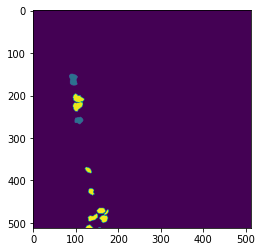

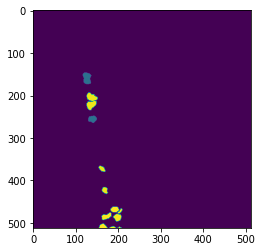

<AxesSubplot:>

In [ ]:
import rasterio
from rasterio.plot import show
from rasterio.windows import from_bounds, Window
from config import UNetTraining
config = UNetTraining.Configuration()
img = rasterio.open(config.filepath_label_compressed)
# 1. inspect image
# get bounding box coordinates, x & y resolution and size of image
img_info = (img.bounds, img.res, img.width, img.height)
print(img_info)
# 2. windowed reading
start_x = start_y = steps_x = steps_y = 512
img_cutout_steps = img.read(None, window=Window(start_x,start_y,steps_x,steps_y))
show(img_cutout_steps)
west, south, east, north = 29.74801671786931, -26.24955085491147, 29.74923159879657, -26.248335973984698
img_cutout_coord = img.read(None, window=from_bounds(west, south, east, north, img.transform))
show(img_cutout_coord)
